<a href="https://colab.research.google.com/github/remisoulignac/scm_optim_problems/blob/main/SCM290-GreenDCLocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ortools==9.8.3296


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 45.4 MB/s eta 0:00:00
  Attempting uninstall: ortools
    Found existing installation: ortools 9.11.4210
    Uninstalling ortools-9.11.4210:
      Successfully uninstalled ortools-9.11.4210


#Week 3 Green Location Problem
FastShipCo has has to deliver 20 locations with various demand level and truck constraints. 5 possible locations have been identified for building distribution centers. Only up to 2 DC can be opened.
Find the best location for the 2 DCs while optimizing total cost including CO2 emissions

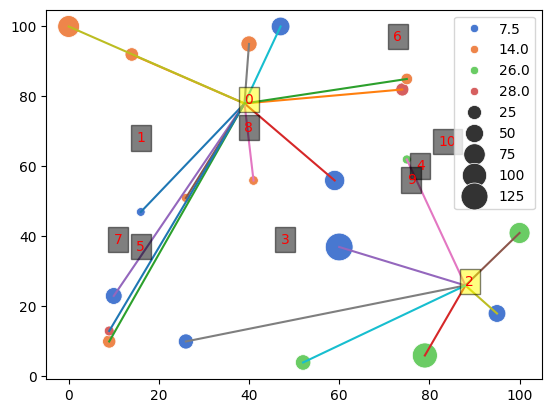

Objective= 30947.164316431954
TotalTransportationCost 30817.96688274649
TotalCarbonEmission 1291.9743368545699
IsDCOpened=
 ['DC0=1' 'DC1=0' 'DC2=1' 'DC3=0' 'DC4=0' 'DC5=0' 'DC6=0' 'DC7=0' 'DC8=0'
 'DC9=0' 'DC10=0']
DoesDCServeNode=
 [['DC0->Node0=0' 'DC0->Node1=1' 'DC0->Node2=0' 'DC0->Node3=1'
  'DC0->Node4=0' 'DC0->Node5=1' 'DC0->Node6=0' 'DC0->Node7=1'
  'DC0->Node8=0' 'DC0->Node9=1' 'DC0->Node10=1' 'DC0->Node11=1'
  'DC0->Node12=1' 'DC0->Node13=1' 'DC0->Node14=1' 'DC0->Node15=1'
  'DC0->Node16=0' 'DC0->Node17=1' 'DC0->Node18=0' 'DC0->Node19=1']
 ['DC1->Node0=0' 'DC1->Node1=0' 'DC1->Node2=0' 'DC1->Node3=0'
  'DC1->Node4=0' 'DC1->Node5=0' 'DC1->Node6=0' 'DC1->Node7=0'
  'DC1->Node8=0' 'DC1->Node9=0' 'DC1->Node10=0' 'DC1->Node11=0'
  'DC1->Node12=0' 'DC1->Node13=0' 'DC1->Node14=0' 'DC1->Node15=0'
  'DC1->Node16=0' 'DC1->Node17=0' 'DC1->Node18=0' 'DC1->Node19=0']
 ['DC2->Node0=1' 'DC2->Node1=0' 'DC2->Node2=1' 'DC2->Node3=0'
  'DC2->Node4=1' 'DC2->Node5=0' 'DC2->Node6=1' 'DC2->Node7=0'


In [12]:
from ortools.sat.python import cp_model
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

INFINITY = cp_model.INT32_MAX
model = cp_model.CpModel()

#helper functions to deal with arrays
add_constraints_eq=np.vectorize(lambda e,c : model.Add(e==c))
add_constraints_ge=np.vectorize(lambda e,c : model.Add(e>=c))
add_constraints_le=np.vectorize(lambda e,c : model.Add(e<=c))
vararray_to_resultarray=np.vectorize(lambda v:solver.Value(v))
vararray_to_results=np.vectorize(lambda v:f'{v.Name()}={solver.Value(v)}')

#-- INPUTS
MaxOpenedDCs=2

#[X in km, Y in km, Demand in unit, TruckSize in Ton]
DemandNodes= np.array([
  [79, 6, 107,  26],
  [16, 47, 2,  7.5],
  [60, 37, 134,  7.5],
  [14, 92, 22,  14],
  [100, 41, 71,  26],
  [9, 10, 21,  14],
  [75, 62, 3,  26],
  [59, 56, 65,  7.5],
  [26, 10, 31,  7.5],
  [10, 23, 41,  7.5],
  [26, 51, 3,  14],
  [41, 56, 5,  14],
  [40, 95, 37,  14],
  [0, 100, 78,  14],
  [47, 100, 54,  7.5],
  [9, 13, 6,  28],
  [95, 18, 47,  7.5],
  [74, 82, 20,  28],
  [52, 4, 33,  26],
  [75, 85, 13,  14]
])

#[X in km, Y in km]
CandidateDCs= np.array([
  [39, 78],
  [15, 67],
  [88, 26],
  [47, 38],
  [77, 59],
  [15, 36],
  [72, 96],
  [10, 38],
  [39, 70],
  [75, 55],
  [82, 66],
])


#Fuel Comsumption : [Truck Size in, FCEmpty in Liter/km, FCFull in Liter/Km]
FC= np.array([
    [7.5, 0.11, 0.134],
    [14, 0.171, 0.228],
    [26, 0.244, 0.352],
    [28, 0.255, 0.402]
])

#Shape:CandidateDCs x DemandNodes
EuclidianDistances=np.array(list(list(math.sqrt((dc[0]-node[0])**2+(dc[1]-node[1])**2) for node in DemandNodes) for dc in CandidateDCs))


#Shape:DemandNodes
FCEmptyForNode=np.array(list(FC[FC[:,0]==truckSize,1][0] for truckSize in DemandNodes[:,3]))
FCFullForNode=np.array(list(FC[FC[:,0]==truckSize,2][0] for truckSize in DemandNodes[:,3]))
LoadFactorForNode=np.array(list(node[2]/node[3] for node in DemandNodes))
CeiledLoadFactorForNode=np.ceil(LoadFactorForNode)
CarbonEmissionFactor=2.6 #Kg of CO2 / Liter
CostPerTonKilometer=1.20 #$ / Ton.km

#- DECISIONS VARIABLES
#Shape : CandidateDCs
IsDCOpened=np.asarray(list(model.NewBoolVar("DC{}".format(dc)) for dc in range(CandidateDCs.shape[0])))
#Shape : DemandNodes x CandidateDCs
DoesDCServeNode=np.asarray(list(list(model.NewBoolVar("DC{}->Node{}".format(dc,node)) for node in range(DemandNodes.shape[0])) for dc in range(CandidateDCs.shape[0])) )

#-- CONSTRAINTS
# each node is served by at most 1 dc
add_constraints_eq(np.sum(DoesDCServeNode, axis=0), 1)
# max opened DCs
add_constraints_eq(np.sum(IsDCOpened), MaxOpenedDCs)
# a node is served if the dc is opened
for dc in range(CandidateDCs.shape[0]):
  add_constraints_le(DoesDCServeNode[dc,:], IsDCOpened[dc])

#to test
#add_constraints_eq(IsDCOpened[2], 1)
#add_constraints_eq(IsDCOpened[3], 1)

#-- OBJECTIVE FUNCTION
CostOfCarbon=0.1 #$ / Kg.CO2
TotalTransportationCost = CostPerTonKilometer*np.sum(np.sum(DemandNodes[:,2]*EuclidianDistances*DoesDCServeNode))
TotalCarbonEmission = CarbonEmissionFactor*np.sum(np.sum(EuclidianDistances*(FCEmptyForNode*CeiledLoadFactorForNode+(FCFullForNode-FCEmptyForNode)*LoadFactorForNode)*DoesDCServeNode))
TotalCost=TotalTransportationCost+CostOfCarbon*TotalCarbonEmission
model.Minimize(TotalCost)

#-- EXECUTION
solver = cp_model.CpSolver()
status = solver.Solve(model)
if status == cp_model.OPTIMAL:
    fig, ax = plt.subplots()
    sns.scatterplot(x=DemandNodes[:,0], y=DemandNodes[:,1], size=DemandNodes[:,2], hue=DemandNodes[:,3],sizes=(40, 400), palette="muted", ax=ax)

    for i in range(CandidateDCs.shape[0]):
      ax.text(x=CandidateDCs[i,0],y=CandidateDCs[i,1],s=i, fontdict=dict(color='red',size=10), bbox=dict(facecolor='yellow' if solver.Value(IsDCOpened[i])==1 else 'black',alpha=0.5))

    for i in range(CandidateDCs.shape[0]):
      for j in range(DemandNodes.shape[0]):
        if solver.Value(DoesDCServeNode[i][j]):
          ax.plot([CandidateDCs[i][0],DemandNodes[j][0]],[CandidateDCs[i][1],DemandNodes[j][1]])
    plt.show()

    print("Objective=", solver.ObjectiveValue())
    print("TotalTransportationCost", solver.Value(TotalTransportationCost) )
    print("TotalCarbonEmission", solver.Value(TotalCarbonEmission) )
    print("IsDCOpened=\n", vararray_to_results(IsDCOpened))
    print("DoesDCServeNode=\n", vararray_to_results(DoesDCServeNode))
else:
    print('No optimal solution found.')
